## Macuject ML Challenge Task

The task is to fit a model to the provided data as closely as possible.

There are 2 datasets provided, a train and a validation set.
Train a model on the train data, and measure its performance on the validation data. The final 'Y' column is the target variable.

For the model training, use either PyTorch or Keras (any version).
For your model, use a standard type of neural net.

Measure its performance using the MAE (mean absolute error).
A reasonably good perforance would be *MAE < 0.006*.

Put your solution in a notebook in a repo in a Github account of your own (if you dont have an account you'll have to create own), and provide us a link to the repo. In your notebook show clearly the MAE you attain.

Some example 'skeleton' code is provided below (in PyTorch) to help you start (if you're using Keras, thats fine, but you'll have to provide equivalent code in Keras).

Please develop/ modify this as you wish, and provide the missing parts to complete model training/ evaluation. For example-
- a model 
- an optimizer, loss function, etc ...
- any other elements to 
    - process/ pre-process data
    - understand, optimise the data, model performance, etc

Show your output and results, and comment on them.

Please indicate how much time you spent on this (this is only for our own purposes in adjusting the test).


In [81]:
import os
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [82]:
# It's a regression task to learn a function that maps X->Y
# load data
train_data=pd.read_csv('train_data.csv').values
val_data=pd.read_csv('validation_data.csv').values
train_inp = train_data[:,0:-1] # Train data X
train_targets = train_data[:,-1] # Train data Y
val_inp = val_data[:,0:-1] # Validation data X
val_targets = val_data[:,-1] # Validation data Y



In [83]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Use single GPU if there are multiple gpu in the machine
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use cpu if there is no gpu
torch.backends.cudnn.benchmark = True # Fasten the run-time
# Initialize seed to a fixed value. Random number are genereted from this seed. It makes the result reproducible.
seed=1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [84]:
# Define Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(targets).float()
    def __getitem__(self, index):
        x = self.data[index].reshape(-1)
        y = self.targets[index].reshape(-1)
        return x, y
    def __len__(self):
        return len(self.data)

In [85]:
# Dataloader for both training and validation dataset
train_loader = DataLoader(CustomDataset(train_inp,train_targets), batch_size=25)
val_loader = DataLoader(CustomDataset(val_inp,val_targets), batch_size=25)


In [86]:
# Define the neural network
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(6,1200,bias=True),nn.ReLU(inplace=True))
        self.fc2 = nn.Sequential(nn.Linear(1200,1200,bias=True),nn.ReLU(inplace=True))
        self.fc3 = nn.Sequential(nn.Linear(1200,1200,bias=True),nn.ReLU(inplace=True))
        self.fc4 = nn.Sequential(nn.Linear(1200,1))
    def forward(self,x):
        h = self.fc1(x)
        h = self.fc2(h)
        h = self.fc3(h)
        h = self.fc4(h)
        return h
model = Net().to(device)

In [87]:
# 3. Define neural network cost funtion, optimiser, learning rate
learning_rate=0.0001 # Define learning rate
criterion = nn.L1Loss(reduction="sum") # Define a loss function. We can use other losses (e.g. L2, SmoothL1 etc) inplace of the L1 loss. However, here our evaluation metrics MAE and this L1 loss both are same function.
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Define the optimiser. We use Adam as our optimizer which is the most widely used optimiser. However we can use other optimiser like SGD, RAdam etc.
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,150], gamma=0.1) # Learning rate scheduler is used to update the learning rate in 'gamma' factor at different epoch stages (e.g. 50, 150).

In [79]:
n_epochs = 200

train_losses = []
val_losses = []
least_MAE=float('inf')
for epoch in range(n_epochs):
    print(f'epoch:{epoch+1}/{n_epochs}')
    train_loss = 0.0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data,target=data.to(device),target.to(device)
        output = model(data)
        loss = criterion(target,output)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
    M_Loss = train_loss / len(train_loader.dataset) # MAE and L1 loss are same function.
    train_losses.append(M_Loss)
    print('Train error: {:.6f}'.format(M_Loss))
    model.eval()
    AE = 0
    with torch.no_grad():
        for data, target in val_loader:
            data,target=data.to(device),target.to(device)
            output = model(data)
            AE += torch.sum(torch.abs(target - output)).item()
    MAE = AE / len(val_loader.dataset)
    val_losses.append(MAE)
    if MAE<least_MAE:
        least_MAE = MAE
        torch.save(model.state_dict(),'params.pth')
    scheduler.step()
    print('Val error: {:.6f}'.format(MAE))
print('----------Training completed-----------')
print(f'Best MAE:{least_MAE}')

epoch:1/200
Train error: 0.035362
Val error: 0.025934
epoch:2/200
Train error: 0.022018
Val error: 0.018387
epoch:3/200
Train error: 0.017100
Val error: 0.014848
epoch:4/200
Train error: 0.013879
Val error: 0.012541
epoch:5/200
Train error: 0.012920
Val error: 0.014900
epoch:6/200
Train error: 0.011895
Val error: 0.012445
epoch:7/200
Train error: 0.009937
Val error: 0.009329
epoch:8/200
Train error: 0.009289
Val error: 0.010133
epoch:9/200
Train error: 0.008258
Val error: 0.010963
epoch:10/200
Train error: 0.009334
Val error: 0.010166
epoch:11/200
Train error: 0.008405
Val error: 0.009762
epoch:12/200
Train error: 0.008405
Val error: 0.011129
epoch:13/200
Train error: 0.008168
Val error: 0.009365
epoch:14/200
Train error: 0.007700
Val error: 0.008772
epoch:15/200
Train error: 0.007211
Val error: 0.008384
epoch:16/200
Train error: 0.006850
Val error: 0.009413
epoch:17/200
Train error: 0.007503
Val error: 0.010488
epoch:18/200
Train error: 0.007554
Val error: 0.007468
epoch:19/200
Train 

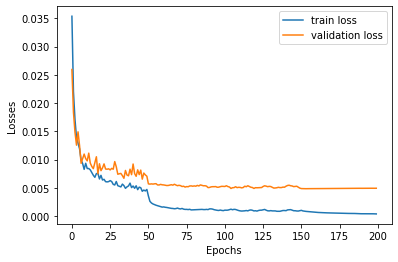

In [80]:
# Plot epoch vs loss graph for train and validation set
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(torch.arange(n_epochs),train_losses,label='train loss')
plt.plot(torch.arange(n_epochs),val_losses,label='validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Losses")
fig.savefig('loss_graph.png')
